In [31]:
!pip install gurobipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [32]:
import gurobipy as gp
from gurobipy import GRB

# test_data = [[4,2,1,1,0],[1,1,1,1,0], [3,2,1,1,1],[4,3,3,3,1],[0,0,2,2,0],[8,8,7,6,3]] #e_ij = 1 if col i exists at level j, bottom to top
test_data = [[0,2,1,1,0],[1,1,1,1,0]]

# num_Sections = 20
# num_Cols = 10
# num_Levels = 10
# min_section_cost = 100
# max_section_cost = 10000

#test_data = generate_instance(num_Sections,num_Cols,num_Levels,min_s_in_c=1,max_s_in_c=4)
#SectionCost = generate_section_costs(num_Sections,min_section_cost,max_section_cost)
SectionCost = [0,20,70]


n_cols = len(test_data)
n_levels = len(test_data[0])
# max_min_groups = 15 #min(n_cols,n_levels) #TODO: NEED NEW HEURISTIC FOR THIS
max_min_groups = 4 #min(n_cols,n_levels) #TODO: NEED NEW HEURISTIC FOR THIS
M = n_levels + 2
M_sections = max([max(i) for i in test_data]) + 1

Xgcl = [(g,c,l) for l in range(n_levels) for c in range(n_cols) for g in range(max_min_groups)]
Gs = [(g,s) for g in range(max_min_groups) for s in range(M_sections)]
Es = [(c,l,s) for s in range(M_sections) for l in range(n_levels) for c in range(n_cols)]

#c,l
S = {(i,j): test_data[i][j] for j in range(n_levels) for i in range(n_cols)}
S_bin = {(i,j,s): 1 if s >= test_data[i][j] else 0 for s in range(M_sections) for j in range(n_levels) for i in range(n_cols)}
E = {(i,j): 1 if test_data[i][j] > 0 else 0 for j in range(n_levels) for i in range(n_cols)}


# Create a new model
model = gp.Model("Grouping-Optimization")

# # Create variables

x = model.addVars(Xgcl, vtype = GRB.BINARY, name="x")

GroupCost = 100
# SectionCost = [0,100,400,800,1600,3200,6400,12800,14000]
sections = set(i for i in range(len(SectionCost)))

group_exists = model.addVars(max_min_groups, vtype = GRB.BINARY, name="group_exists")
column_in_group = model.addVars(max_min_groups, n_cols, vtype = GRB.BINARY, name="col_in_group")
level_in_group = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="level_in_group")

# can these be continuous? or must be int?
group_lower_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_lb", lb = 0, ub = n_levels)
group_upper_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_ub", lb = 0, ub = n_levels)
group_level_range = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_range", lb = 0, ub = n_levels)

#section size variables
group_section = model.addVars(Gs, vtype = GRB.BINARY, name="group_section")
element_section = model.addVars(Es, vtype=GRB.BINARY, name="element_section")
# Zs = model.addVars(Xgcl, vtype = GRB.BINARY, name = "Zs") #if group section = element section

#each group is same section
#group section has to be >= section of element
#take min of cost_of_section * num of elements with that section
#^either count # of sections in each group, and linearize cost_of_section var * # sections
#that is for integer version, binary version has binary var for which section a grou phas, times its cost, times number of elements
# or has bin var for section of each element, and multiple by cost of that section.
# 4 variations??

Zu = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zu")
Zl = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zl")

In [33]:
for c in range(n_cols):
  for l in range(n_levels):
    #sum of Xgcl over all groups must = if col at that level exists
    model.addConstr(gp.quicksum(x[g,c,l] for g in range(max_min_groups)) == E[c,l])
    model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) >= S[c,l])
    # model.addConstr(gp.quicksum(element_section[c,l,s] for s in range(M_sections)) == 1)

  for l in range(1,n_levels):
    if E[c,l] == 1:
      model.addConstr(gp.quicksum(s*element_section[c,l,s] for s in range(M_sections)) >= gp.quicksum((s*element_section[c,l-1,s] for s in range(M_sections))))

for g in range(max_min_groups):
  #range of group g = upper bound - lower bound
  model.addConstr(group_level_range[g] == group_upper_bound[g] - group_lower_bound[g])

  #1 section per group
  model.addConstr(gp.quicksum(group_section[g,s] for s in range(M_sections)) == 1)

  for c in range(n_cols):
    for l in range(n_levels):

      #if element is in a group, it's section is at least the group's
      #if not in the group, it's greater than (at most) 0
      #TODO: these are problems constraints.
      model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) >= gp.quicksum(s * group_section[g,s] for s in range(M_sections)) - (M_sections+1)*(1-x[g,c,l]))
      model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) <= gp.quicksum(s * group_section[g,s] for s in range(M_sections)) + (M_sections+1)*(1-x[g,c,l]))

      #if element is in group, that column is in the group
      model.addConstr(column_in_group[g,c] >= x[g,c,l])

      #if element is in group, that level is in the group
      model.addConstr(level_in_group[g,l] >= x[g,c,l])

      #if element is in that group, that group exists
      model.addConstr(group_exists[g] >= x[g,c,l])

for g in range(max_min_groups):
  for l in range(n_levels):

    #calculate upper, lower level
    #NOTE: need to min(Ug) and max(Lg) for this to work
    #NOTE: in julia, everything is 1 based, might need to adjust formulation to make everything work as 0-based
    model.addConstr(l*level_in_group[g,l] <= group_upper_bound[g])
    model.addConstr(l*level_in_group[g,l] + M*(1-level_in_group[g,l]) >= group_lower_bound[g])

    #set Zl
    model.addConstr(M*Zl[g,l] >= l-group_lower_bound[g]+1)
    model.addConstr(M*(1-Zl[g,l]) >= group_lower_bound[g]-l)

    #set Zu
    model.addConstr(M*Zu[g,l] >= group_upper_bound[g]-l+1)
    model.addConstr(M*(1-Zu[g,l]) >= l-group_upper_bound[g])

    #if a level is within lower/upper bound, it's in the group
    model.addConstr(1+level_in_group[g,l] >= Zu[g,l]+Zl[g,l])

    # for c in range(n_cols):
      #if column and level are in the group, so is the element
      #todo: lazily constraint??
      # model.addConstr(column_in_group[g,c]+level_in_group[g,l] <= 1 + x[g,c,l])

In [34]:
def lazy_callback(model, where):
    if where == GRB.Callback.MIPSOL:  # Check if a new solution is found
        # Retrieve the values of decision variables at the current solution
        column_vals = model.cbGetSolution(column_in_group)
        level_vals = model.cbGetSolution(level_in_group)
        x_vals = model.cbGetSolution(x)

        # Iterate through indices and add violated constraints
        for g in range(max_min_groups):
            for l in range(n_levels):
                for c in range(n_cols):
                    lhs = column_vals[g, c] + level_vals[g, l]  # Left-hand side
                    rhs = 1 + x_vals[g, c, l]  # Right-hand side
                    if lhs > rhs + 1e-6:  # Constraint is violated
                        model.cbLazy(column_in_group[g, c] + level_in_group[g, l] <= 1 + x[g, c, l])

In [35]:
model.setObjective(gp.quicksum(element_section[c,l,s] * SectionCost[s] for s in range(M_sections) for c in range(n_cols) for l in range(n_levels)) + GroupCost*gp.quicksum(group_exists),GRB.MINIMIZE)

<ipython-input-35-cbabd68e51fc>:1: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective(gp.quicksum(element_section[c,l,s] * SectionCost[s] for s in range(M_sections) for c in range(n_cols) for l in range(n_levels)) + GroupCost*gp.quicksum(group_exists),GRB.MINIMIZE)


In [36]:
# model.write("group-optim-toy.lp")

# Optimize model
# model.optimize()
model.Params.LazyConstraints = 1

model.optimize(lazy_callback)

ns = 0
for v in model.getVars():
    if "group_exists" in v.VarName and v.X > 0.5:
      ns += 1
        # print(f"{v.VarName}, {v.x:g}") #{v.X:g}")

print(f"Obj: {model.ObjVal:g}")
print(f"Time: {model.Runtime:g}")

print("Groups: ", ns)

print(test_data)
print(SectionCost)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
LazyConstraints  1

Optimize a model with 374 rows, 166 columns and 1044 nonzeros
Model fingerprint: 0x5348db0b
Variable types: 0 continuous, 166 integer (154 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 103 rows and 26 columns
Presolve time: 0.02s
Presolved: 271 rows, 140 columns, 650 nonzeros
Variable types: 0 continuous, 140 integer (128 binary)

Root relaxation: objective 3.900000e+02, 97 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent  

In [37]:
grouped_elements = np.full((n_cols, n_levels), -1)  # -1 as default (if element doesn't exist)

for g, i, j in x.keys():
    if x[g, i, j].X > 0.5:  # Check if x[g, i, j] is active
        grouped_elements[i, j] = g

print(grouped_elements)

[[-1  2  2  2 -1]
 [ 0  0  0  0 -1]]


In [38]:
section_of_elements = np.full((n_cols, n_levels), 0)

for c, l, s in element_section.keys():
    if element_section[c, l, s].X > 0.5:
      section_of_elements[c, l] = s
    # print(f"column {c}, level {l}, section {s}: {element_section[c,l,s].X}")

print(section_of_elements)

[[0 2 2 2 0]
 [1 1 1 1 0]]


In [39]:
def heatmap(color_vals, annot_vals):
  unique_values_1 = np.unique(color_vals)
  unique_values_1 = unique_values_1[unique_values_1 != -1]

  unique_values_2 = np.unique(annot_vals)
  unique_values_2 = unique_values_2[unique_values_2 > 0]

  palette_1 = sns.color_palette("viridis", len(unique_values_1))
  palette_2 = sns.color_palette("viridis", len(unique_values_2))

  color_dict_1 = {-1: (1, 1, 1)}  # White for -1
  for val, color in zip(unique_values_1, palette_1):
      color_dict_1[val] = color

  color_dict_2 = {0: (1, 1, 1)}  # White for 0
  for val, color in zip(unique_values_2, palette_2):
      color_dict_2[val] = color

  sorted_vals_1 = np.sort(list(color_dict_1.keys()))
  cmap_1 = mcolors.ListedColormap([color_dict_1[val] for val in sorted_vals_1])

  sorted_vals_2 = np.sort(list(color_dict_2.keys()))
  cmap_2 = mcolors.ListedColormap([color_dict_2[val] for val in sorted_vals_2])

  bounds_1 = np.append(sorted_vals_1, sorted_vals_1[-1] + 1) - .5
  norm_1 = mcolors.BoundaryNorm(bounds_1, cmap_1.N)

  bounds_2 = np.append(sorted_vals_2, sorted_vals_2[-1] + 1) - .5
  norm_2 = mcolors.BoundaryNorm(bounds_2, cmap_2.N)

  fig, axes = plt.subplots(1,2,figsize=(10,5))

  sns.heatmap(np.rot90(color_vals), annot=np.rot90(annot_vals), cmap=cmap_1, norm=norm_1,
              linewidths=0.5, linecolor="black", cbar=False, ax=axes[0])

  ax2 = sns.heatmap(np.rot90(annot_vals), annot=np.rot90(color_vals), cmap=cmap_2, norm=norm_2,
                    linewidths=.5, linecolor="black", cbar=True, ax=axes[1])

  # customizing the cbar
  cbar = ax2.collections[0].colorbar
  cbar.set_ticks(sorted_vals_2)
  cbar.set_ticklabels(sorted_vals_2)

  axes[0].set_title("Grouping of elements")
  axes[1].set_title("Section of elements")

  axes[0].axis("off")
  axes[1].axis("off")

  plt.tight_layout()
  plt.show()

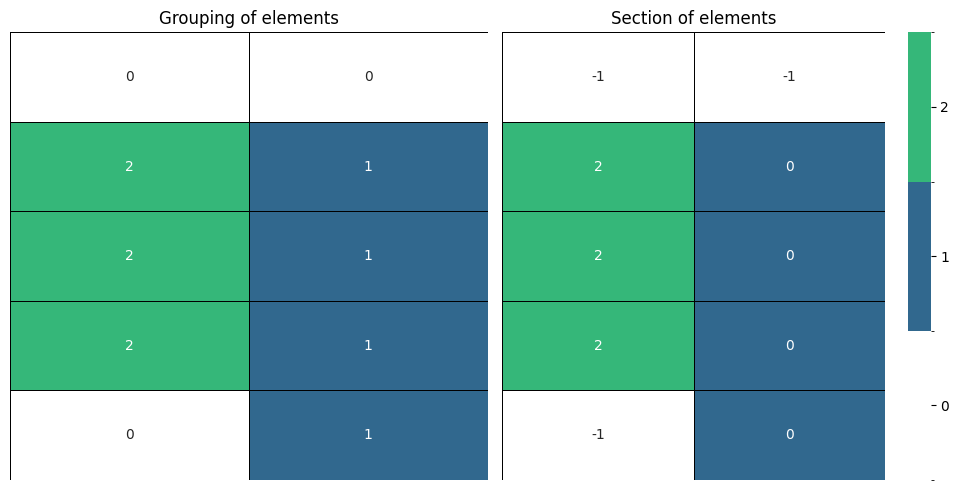

In [40]:
heatmap(grouped_elements, section_of_elements)